In [1]:
import pathlib as pl

import matplotlib.pyplot as plt
import numpy as np

from src.metrics.significance import _significance as impsig

from ipywidgets import interact, fixed

In [2]:
# values used to load data with Mateo fucntions
site = 'CRD004a'
probes = [1, 2, 3, 4] #permutations
contexts = [0, 1, 2, 3, 4]
meta = {'reliability': 0.1,  # r value
        'smoothing_window': 0,  # ms
        'raster_fs': 30,
        'transitions': [0,1,2,3,4],
        'montecarlo': 1000,
        'zscore': True,
        'dprime_absolute': None,
        'stim_type': 'permutations'}

loads pickled data, These are the outputs of src.metrics.consolidated_dprime.single_cell_dprimes(site, probes, meta)

this is single unit data, which is more suceptible to spureous significant bins, and which presents lots of heterogeneity
in response and therefore contextual effects across different combinations of Ctx_Pair and Probes.

This data comes from the all permutations dataset, which with 5 different contexts, presents 10 different Ctx_Pairs
This site was selected since it shows the highese value of contextual effects integration (amplitude)
across multiple cells, and after dPCA:
1. CRD004a-39-2, 15 in the cell dimension.
2. CRD004a-64-1, 41

...

In [3]:
dprime = np.load(pl.Path('/auto/users/mateo/multiple_comparisons/eg_dprime.npy')) # shape Units x Ctx_Pair x Probe x Time
shuffled_dprimes = np.load(pl.Path('/auto/users/mateo/multiple_comparisons/eg_shuffle.npy')) # shape Montecarlos x Units x Ctx_Pair x Probe x Time
print(dprime.shape)
print(shuffled_dprimes.shape)

(42, 10, 4, 30)
(1000, 42, 10, 4, 30)


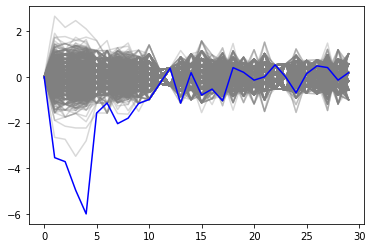

In [4]:
# good example cell
fig, ax = plt.subplots()
cell = 15
ctx_pair = 2
probe = 3

_=ax.plot(shuffled_dprimes[:, cell, ctx_pair, probe,:].T, color='gray', alpha=0.3)
_=ax.plot(dprime[cell, ctx_pair, probe,:], color='blue')

In [5]:
def  _significance(array, mont_array, multiple_comparisons_axis, alpha=0.01, tails='both'):
    """
    calculates significance (boolean) for the values of array using the montecarlo method e.g. n simulations or shuffles of the
    original data in array. These n repetitions are specified in the mont_array, therefore mont_array should have the
    same shape as array plus an aditional first dimension for said repetitions. Correction for multiple comparisons is
    performed across the specified axies. alpha defines the threshold for considering pvalues as significant. tails
    specify wheter calculate a one tailed (upper or lower) or two tailed pvalue.
    :param array: ndarray e.g. Unit x Context x ...
    :param mont_array: ndarray e.g. Montecarlo x Unit x Context ...
    :param multiple_comparisons_axis: list of ints
    :param alpha: float [0:1]
    :param tails: str, 'lesser', 'Greater', 'Both'
    :return:
    """

    mont_num = mont_array.shape[0] # number of montecarlo repetitions

    if tails is 'both':
        pvalues = np.sum(np.abs(mont_array) >= np.abs(array), axis=0) / mont_num
    elif tails == 'greater':
        pvalues = np.sum((mont_array >= array), axis=0) / mont_num
    elif tails == 'lesser':
        pvalues = np.sum((mont_array >= array), axis=0) / mont_num
    else:
        raise ValueError("tails must be 'greater' 'lesser' or 'both'")

    significance = pvalues <= alpha

    n_comparisons = np.prod(np.asarray(significance.shape)[np.asarray(multiple_comparisons_axis)])
    n_chance_comp = np.ceil(n_comparisons * alpha)

    # count the number of significant bins pooling acrooss the multiple comparisons axis, this is done independently
    # across all the other non specified axis, e.g. the Unit dimension
    sig_count = np.sum(significance, axis=tuple(multiple_comparisons_axis), keepdims=True)

    # creates a corrected significance by taking the significant bins of a groups of multiple comparisons, if the sum
    # of significant bins is over the chance comparisons threshold
    # ToDo this is where the next step is unclear, what do we need to do when we pass or fail the treshold?
    corrected_signif = np.where(sig_count > n_chance_comp, significance, np.full(significance.shape, False))

    if not np.allclose(corrected_signif, significance):
        print('significance and corrected_signif are different')

    # defines the confidence intervals as the top and bottom percentiles summing to alpha
    low = alpha * 100
    high = (1 - alpha) * 100
    confidence_interval = np.percentile(mont_array, [low, high], axis=0)

    return significance, corrected_signif, confidence_interval

In [6]:
# runs significance, correcting for multiple comparisons across selected dimensions
alpha = 0.01
# multiple_comparisons = [1, 2, 3] # ctx_pair, probe, time
multiple_comparisons = [3] # time, most astringent (?) 30
# multiple_comparisons = [1, 3] # ctx_pair time 10 x 30

signif, corr_siginif, CI = _significance(dprime, shuffled_dprimes, multiple_comparisons, alpha=alpha)

print(f'singif shape {signif.shape}')
print(f'corr_singif shape {corr_siginif.shape}')
print(f'CI shape {CI.shape}')

significance and corrected_signif are different
singif shape (42, 10, 4, 30)
corr_singif shape (42, 10, 4, 30)
CI shape (2, 42, 10, 4, 30)


now we can plot the original dprime plus its confidece interval and significant bins.
lets keep the same example for now.

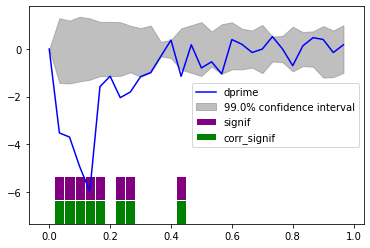

In [7]:
t = np.linspace(0, 1, dprime.shape[-1], endpoint=False) #

fig, ax = plt.subplots()
_ = ax.plot(t, dprime[cell, ctx_pair, probe, :], color='blue', label='dprime')
_ = ax.fill_between(t, CI[0, cell, ctx_pair, probe, :], CI[1,cell, ctx_pair, probe, :],
                color='gray', alpha=0.5, label=f'{(1-alpha)*100}% confidence interval')

ax_bott = ax.get_ylim()[0]
_ = ax.bar(t, signif[cell, ctx_pair, probe, :], width=1/30, align='center', color='purple',
       edgecolor='white', bottom=ax_bott, label='signif')

_ = ax.bar(t, corr_siginif[cell, ctx_pair, probe, :], width=1/30, align='center', color='green',
       edgecolor='white', bottom=ax_bott-1, label='corr_signif')

_ = ax.legend()

we se no difference between the original and corrected significance, even for the last significant time bin at 0.4 s.
which seem to be spurious. This is expected by the desing of the multiple comparions correction, since there are plenty
of significant bins that look legitimate. also, that last bin should not affect much the integration and center of
mass metrics given the amplitude for the other significant bins.

I guess we could figure out a way of filtereing out these kind of bins but sounds overly complicated.


Lets finda a better example

In [8]:
@interact(cell=(0,41), ctx_pair=(0,9), probe=(0,3))
def plot_example(cell, ctx_pair, probe):
    fig, ax = plt.subplots()
    _ = ax.plot(t, dprime[cell, ctx_pair, probe, :], color='blue', label='dprime')
    _ = ax.fill_between(t, CI[0, cell, ctx_pair, probe, :], CI[1,cell, ctx_pair, probe, :],
                    color='gray', alpha=0.5, label=f'{(1-alpha)*100}% confidence interval')

    ax_bott = ax.get_ylim()[0]
    _ = ax.bar(t, signif[cell, ctx_pair, probe, :], width=1/30, align='center', color='purple',
           edgecolor='white', bottom=ax_bott, label='signif')

    _ = ax.bar(t, corr_siginif[cell, ctx_pair, probe, :], width=1/30, align='center', color='green',
           edgecolor='white', bottom=ax_bott-1, label='corr_signif')

    _ = ax.legend()
    return fig, ax

interactive(children=(IntSlider(value=20, description='cell', max=41), IntSlider(value=4, description='ctx_pai…

Multiple comparisons are corrected across contexte_pairs, so if one context pair shows both green and purple significiance
all context pairs for that cell-probe combination will.
to explore I would in order change cell, then probe then context pair.

some examples I found:
1. cell=20, ctx_pair=0, probe=1
2. cell=3, ctx_pari=any, probe=3 this is a problematic example in which a lot or random significacne get to pass the
filter just because there is enough of them across all contexts.
3. cell=4, ctx_pair=any, probe=0, problematic for the same reason as before
4. cell=4, ctx_pair=9, probe=2. In this case there is a single instance of correct rejection.

### the function has been refactored into the package, the following code is to make sure that they are working equally
since some form changes were done.

In [9]:
imp_signif, imp_corr_siginif, imp_CI = impsig(dprime, shuffled_dprimes, multiple_comparisons, alpha=alpha)
print('are the functions equal?: ' + str(np.all(imp_signif == signif)))


are the functions equal?: True
